# MLP
Mean RCI over 14 cell lines.

This notebook uses
lncRNA, canonical, yes middle-exclusion train, yes middle-exclusion test, -1 threshold, learning module, cross-validation.

In [1]:
SEED = 43
import tensorflow as tf
tf.random.set_seed(SEED) 
tf.keras.backend.set_floatx('float32')
import numpy as np
np.random.seed(SEED) 
from datetime import datetime
print(datetime.now())

2023-04-29 16:49:47.440462


In [2]:
import sys
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    print('GPU device not found')
else:
    print('Found GPU at: {}'.format(device_name))

try:
    from google.colab import drive
    IN_COLAB = True
    print('Running on CoLab')
    PATH='/content/drive/'
    drive.mount(PATH)
    DATA_DIR=PATH+'My Drive/data/Localization/TrainTest/TrainTest_ver43/'  # must end in "/"
    MODEL_DIR=PATH+'My Drive/data/Localization/Models/'  # must end in "/"
    sys.path.append('/content/drive/My Drive/Colab Notebooks')
except:
    IN_COLAB = False
    DATA_DIR="/"
    MODEL_DIR="/"
print(DATA_DIR)
SAVE_MODEL_FILENAME = None # 'MLP'
SAVE_DESCRIM_FILENAME = None # 'GMM'
LOAD_MODEL_FILENAME = None # 'MLP.0.0.model'
LOAD_DESCRIM_FILENAME = None # 'GMM.0.0.pickle'

GPU device not found
Running on CoLab
Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/


In [3]:
from platform import python_version
print('Python',python_version())
import pandas as pd
import scipy.stats as ss
import pickle
import time # sleep function
from os.path import isfile
from matplotlib import pyplot as plt 
import sklearn   # pip install --upgrade scikit-learn
print('sklearn',sklearn.__version__)

from learning import DataLoader, CrossValidator, Separator, ModelBuilder

K=5
ALPHABET=4**K + 1
EPOCHS=300 
EMBED_DIMEN = 4 # arbitrary hyperparameter
RCI_THRESHOLD_MECHANISM = 'ZERO'   # 'RCI_GMM' 'ZERO' 'THE_MEAN'
RCI_THRESHOLD_VALUE = -1  # use -1 for lncRNA, use 0 for mRNA
BREAK = False   # optionally break after first fold
FILTER_TRAIN        = True
FILTER_TAILS_TRAIN  = False
FILTER_MIDDLE_TRAIN = True
FILTER_TEST         = True
FILTER_TAILS_TEST   = False
FILTER_MIDDLE_TEST  = True
MIDDLE_LOW          = -2   # -2 for lncRNA, -1 for mRNA
MIDDLE_HIGH         = 0    #  0 for lncRNA, +1 for mRNA

REPEATS = 2
FOLDS = 5

Python 3.10.11
sklearn 1.2.2


In [4]:
RCI_FILE_TRAIN = 'train.lncRNA_RCI.all_cell_lines.csv'
RCI_FILE_TEST  = None # 'test.lncRNA_RCI.all_cell_lines.csv'

SEQ_FILE_TRAIN = 'train.canon_lncRNA_transcripts.csv'
SEQ_FILE_TEST  = None # 'test.canon_lncRNA_transcripts.csv'

In [5]:
def get_ordered_list():
    ordered_list = \
    ['A549','H1.hESC','HeLa.S3','HepG2','HT1080',\
      'HUVEC','MCF.7','NCI.H460','NHEK','SK.MEL.5',\
      'SK.N.DZ','SK.N.SH','GM12878','K562','IMR.90']
    return ordered_list
all_cell_lines = get_ordered_list()
EXCLUSIONS = [1]  # H1.hESC   
print('Exclusions',EXCLUSIONS)

Exclusions [1]


In [6]:
from tensorflow import keras
from keras import models
import pickle

def save_model(model, discriminator, filename1, filename2):
    filepath = MODEL_DIR + filename1
    model.save(filepath)
    print('Saved model 1 to',filepath)
    filepath = MODEL_DIR + filename2
    pickle.dump(discriminator, open(filepath, 'wb'))
    print('Saved model 2 to',filepath)

def load_model(filename1, filename2):
    filepath = MODEL_DIR + filename1
    model = keras.models.load_model(filepath)
    print('Loaded model 1 from',filepath)
    filepath = MODEL_DIR + filename2
    discriminator = pickle.load(open(filepath, 'rb'))        
    print('Loaded model 2 from',filepath)
    return model, discriminator
        

2023-04-29 16:49:50.221187
Load RCI from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.lncRNA_RCI.all_cell_lines.csv
Number of RCI values loaded 4372
Num RCI: 4372
Load sequence from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.canon_lncRNA_transcripts.csv
Loaded 4372 sequences.

Training # 1 1
2023-04-29 16:49:59.222556
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.1.1.validation_genes.txt
Discriminator ZERO -1
Train 1:0 1062:1013 51.18%
Computed class weights: {0: 1.0241855873642645, 1: 0.9769303201506592}
Valid 1:0 259:273 48.68%
FIT


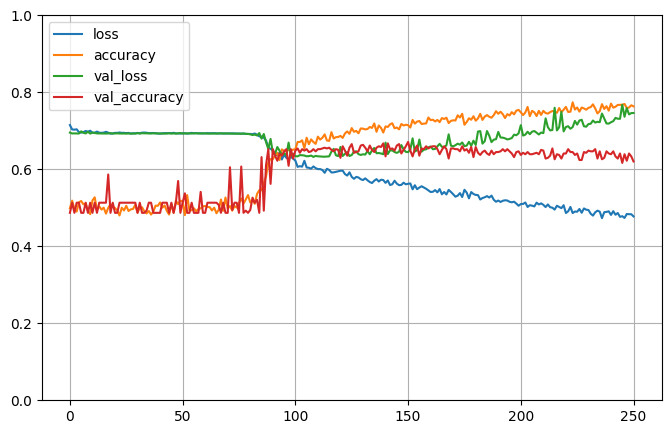


Testing # 1 1
2023-04-29 16:52:23.410552
PREDICT
Test 1:0 259:273 48.68%
Predict 1:0 286:246 53.76%
Test sizes (532, 1025) (532,)
Distrib of scores: 0.5083999 mean 0.23482159 std
Range of scores: 0.020890886 to 0.9450385
Score threshold 0.5
Confusion matrix
 [[172 101]
 [ 74 185]]
Normalized matrix
 [[0.32330827 0.18984962]
 [0.13909774 0.34774436]]
Extreme scores correct, pos:neg 115 107
Extreme scores incorrect pos:neg 53 35


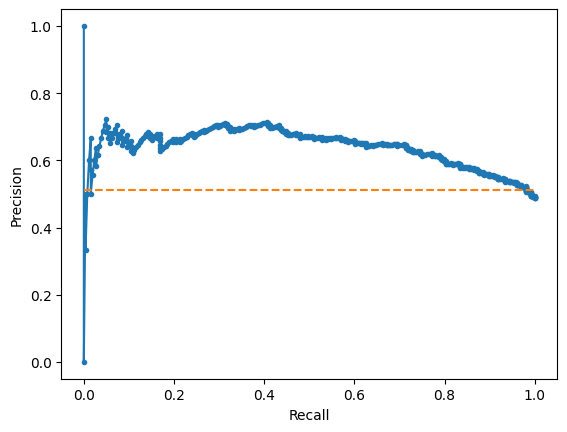

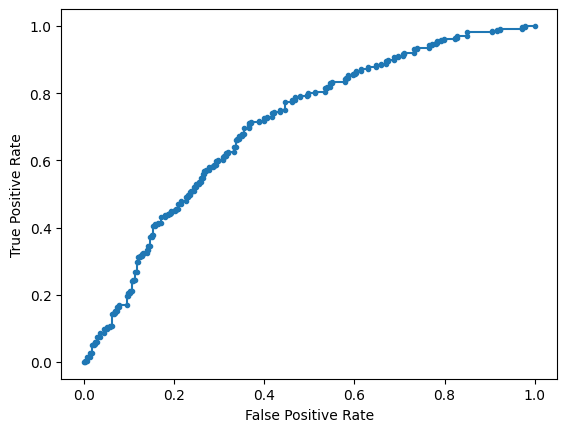

Accuracy: 67.11% Precision: 64.69% Recall: 71.43%
F1: 67.89% MCC: 0.3452
AUPRC: 63.90% AUROC: 70.27%
 accuracy [67.10526315789474]
 precision [64.6853146853147]
 recall [71.42857142857143]
 F1 [67.88990825688074]
 MCC [0.3451801729456012]
 AUPRC [63.90435414197828]
 AUROC [70.27168455739886]

Training # 1 2
2023-04-29 16:52:24.083506
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.1.2.validation_genes.txt
Discriminator ZERO -1
Train 1:0 1048:1016 50.78%
Computed class weights: {0: 1.015748031496063, 1: 0.9847328244274809}
Valid 1:0 273:270 50.28%
FIT


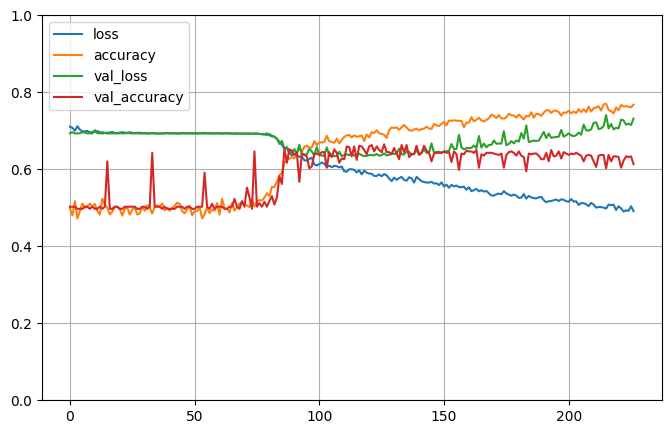


Testing # 1 2
2023-04-29 16:53:54.631681
PREDICT
Test 1:0 273:270 50.28%
Predict 1:0 343:200 63.17%
Test sizes (543, 1025) (543,)
Distrib of scores: 0.55970037 mean 0.20267448 std
Range of scores: 0.03620645 to 0.9344666
Score threshold 0.5
Confusion matrix
 [[144 126]
 [ 56 217]]
Normalized matrix
 [[0.26519337 0.2320442 ]
 [0.10313076 0.39963168]]
Extreme scores correct, pos:neg 139 74
Extreme scores incorrect pos:neg 72 19


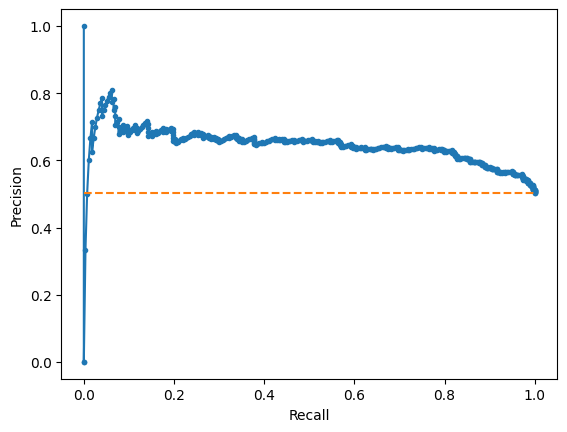

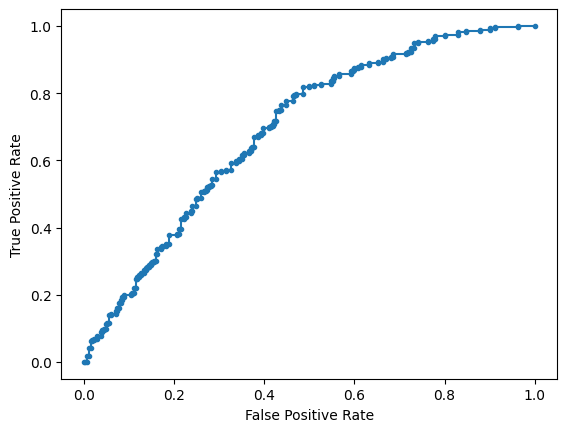

Accuracy: 66.48% Precision: 63.27% Recall: 79.49%
F1: 70.45% MCC: 0.3402
AUPRC: 64.48% AUROC: 69.21%
 accuracy [66.48250460405156]
 precision [63.26530612244898]
 recall [79.48717948717949]
 F1 [70.45454545454547]
 MCC [0.3402095577304003]
 AUPRC [64.47508608906378]
 AUROC [69.2144892144892]

Training # 1 3
2023-04-29 16:53:55.502796
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.1.3.validation_genes.txt
Discriminator ZERO -1
Train 1:0 1070:1030 50.95%
Computed class weights: {0: 1.0194174757281553, 1: 0.9813084112149533}
Valid 1:0 251:256 49.51%
FIT


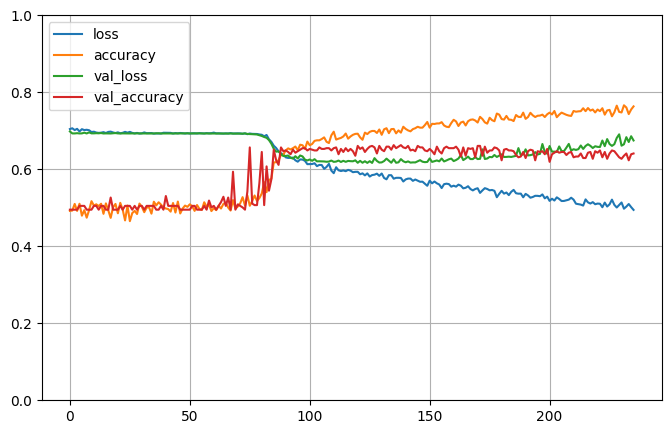


Testing # 1 3
2023-04-29 16:56:19.992120
PREDICT
Test 1:0 251:256 49.51%
Predict 1:0 330:177 65.09%
Test sizes (507, 1025) (507,)
Distrib of scores: 0.5603084 mean 0.19132388 std
Range of scores: 0.03953303 to 0.89226097
Score threshold 0.5
Confusion matrix
 [[131 125]
 [ 46 205]]
Normalized matrix
 [[0.25838264 0.24654832]
 [0.09072978 0.40433925]]
Extreme scores correct, pos:neg 125 67
Extreme scores incorrect pos:neg 62 11


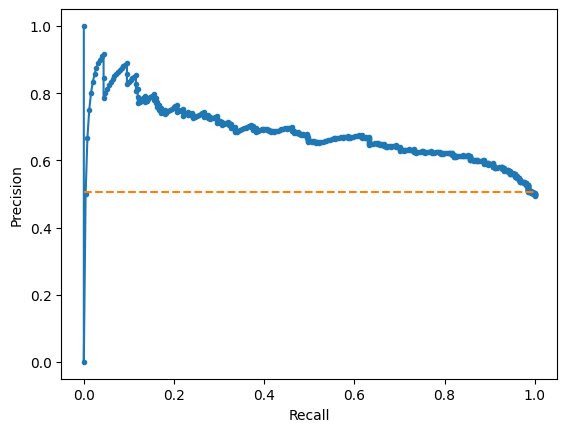

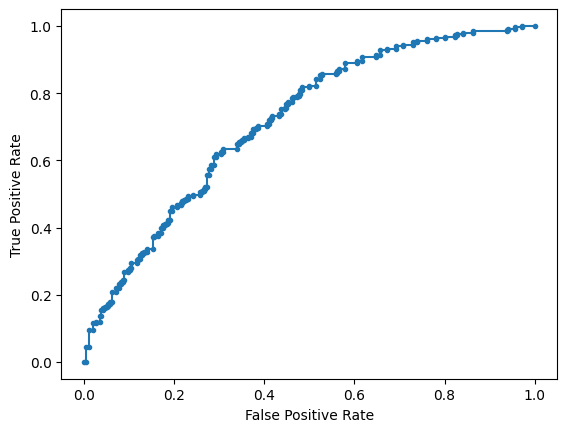

Accuracy: 66.27% Precision: 62.12% Recall: 81.67%
F1: 70.57% MCC: 0.3445
AUPRC: 68.15% AUROC: 71.57%
 accuracy [66.27218934911244]
 precision [62.121212121212125]
 recall [81.67330677290838]
 F1 [70.56798623063682]
 MCC [0.3444965761769523]
 AUPRC [68.1525398571435]
 AUROC [71.57463894422311]

Training # 1 4
2023-04-29 16:56:20.603147
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.1.4.validation_genes.txt
Discriminator ZERO -1
Train 1:0 1064:1041 50.55%
Computed class weights: {0: 1.01104707012488, 1: 0.9891917293233082}
Valid 1:0 257:245 51.20%
FIT


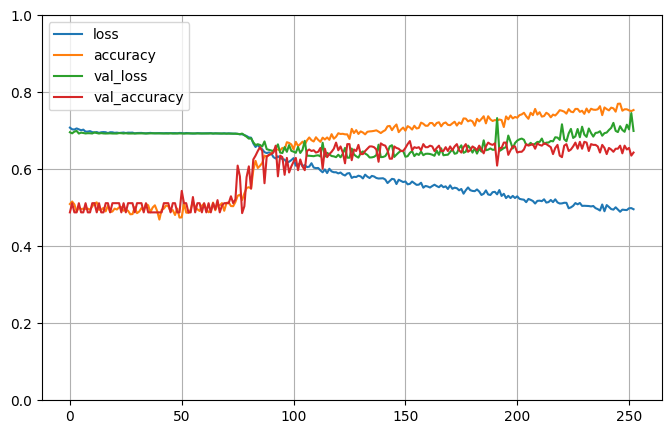


Testing # 1 4
2023-04-29 16:58:44.058319
PREDICT
Test 1:0 257:245 51.20%
Predict 1:0 355:147 70.72%
Test sizes (502, 1025) (502,)
Distrib of scores: 0.58393997 mean 0.20406361 std
Range of scores: 0.025565196 to 0.91707444
Score threshold 0.5
Confusion matrix
 [[114 131]
 [ 33 224]]
Normalized matrix
 [[0.22709163 0.26095618]
 [0.06573705 0.44621514]]
Extreme scores correct, pos:neg 148 59
Extreme scores incorrect pos:neg 65 16


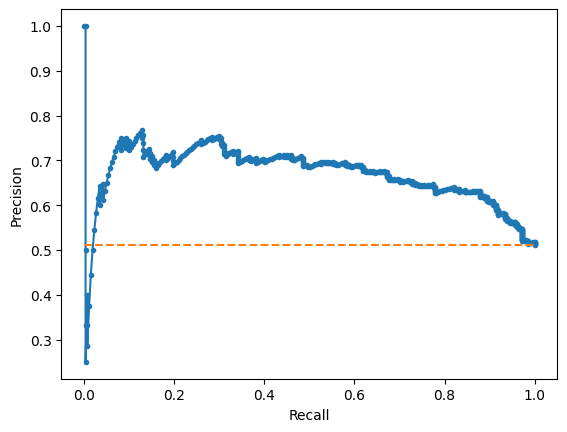

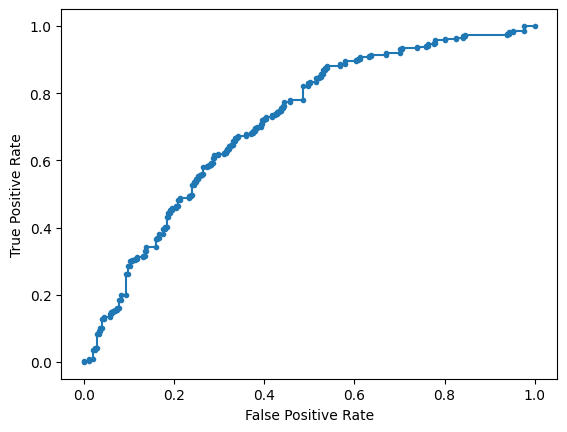

Accuracy: 67.33% Precision: 63.10% Recall: 87.16%
F1: 73.20% MCC: 0.3701
AUPRC: 66.99% AUROC: 71.19%
 accuracy [67.33067729083665]
 precision [63.098591549295776]
 recall [87.15953307392996]
 F1 [73.20261437908498]
 MCC [0.3700663905302345]
 AUPRC [66.98652780602721]
 AUROC [71.1871674739935]

Training # 1 5
2023-04-29 16:58:44.661618
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.1.5.validation_genes.txt
Discriminator ZERO -1
Train 1:0 1040:1044 49.90%
Computed class weights: {0: 0.9980842911877394, 1: 1.001923076923077}
Valid 1:0 281:242 53.73%
FIT


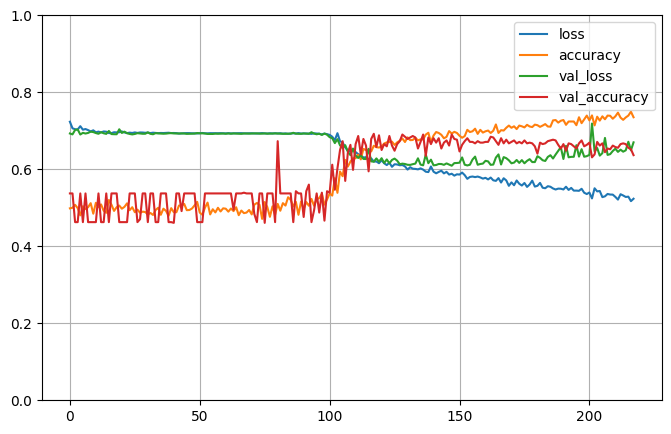


Testing # 1 5
2023-04-29 17:00:09.838249
PREDICT
Test 1:0 281:242 53.73%
Predict 1:0 258:265 49.33%
Test sizes (523, 1025) (523,)
Distrib of scores: 0.5153631 mean 0.16907398 std
Range of scores: 0.13117471 to 0.9218023
Score threshold 0.5
Confusion matrix
 [[173  69]
 [ 92 189]]
Normalized matrix
 [[0.33078394 0.13193117]
 [0.17590822 0.36137667]]
Extreme scores correct, pos:neg 89 70
Extreme scores incorrect pos:neg 33 19


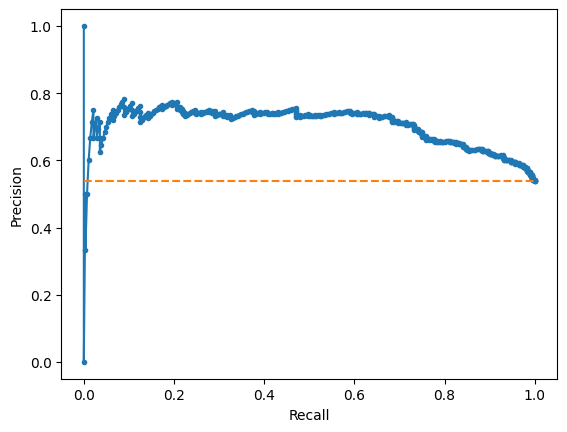

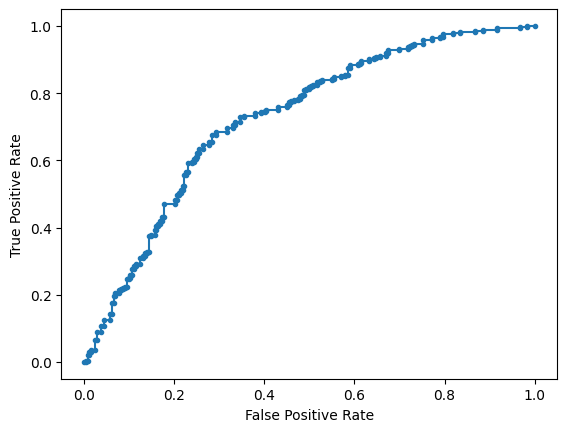

Accuracy: 69.22% Precision: 73.26% Recall: 67.26%
F1: 70.13% MCC: 0.3864
AUPRC: 70.40% AUROC: 72.60%
 accuracy [69.21606118546845]
 precision [73.25581395348837]
 recall [67.25978647686833]
 F1 [70.12987012987013]
 MCC [0.38642970603976656]
 AUPRC [70.40343868076138]
 AUROC [72.60227640363519]

Training # 2 1
2023-04-29 17:00:10.437270
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.2.1.validation_genes.txt
Discriminator ZERO -1
Train 1:0 1060:1030 50.72%
Computed class weights: {0: 1.0145631067961165, 1: 0.9858490566037735}
Valid 1:0 261:256 50.48%
FIT


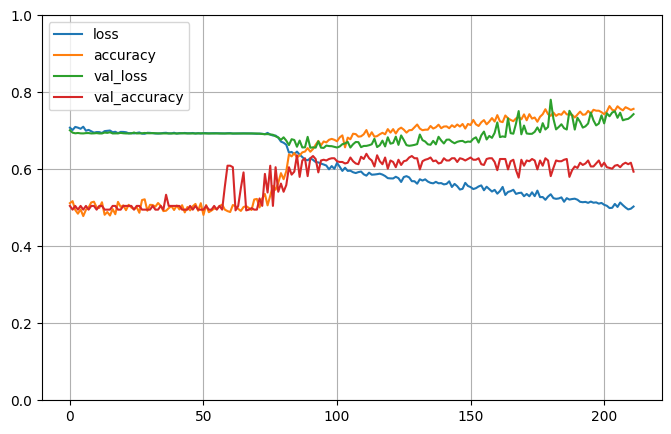


Testing # 2 1
2023-04-29 17:02:33.788030
PREDICT
Test 1:0 261:256 50.48%
Predict 1:0 259:258 50.10%
Test sizes (517, 1025) (517,)
Distrib of scores: 0.49777493 mean 0.20412819 std
Range of scores: 0.038763255 to 0.92000973
Score threshold 0.5
Confusion matrix
 [[164  92]
 [ 94 167]]
Normalized matrix
 [[0.3172147  0.17794971]
 [0.18181818 0.32301741]]
Extreme scores correct, pos:neg 97 95
Extreme scores incorrect pos:neg 41 42


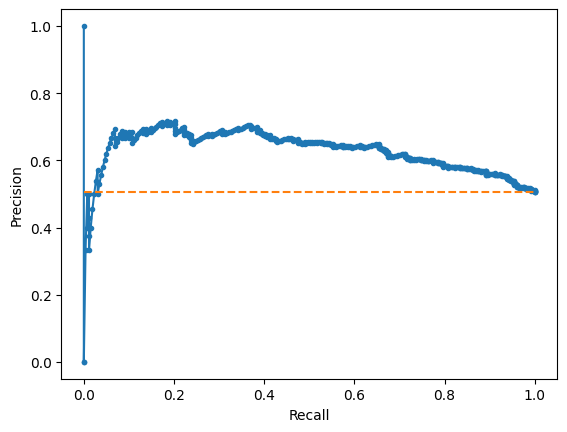

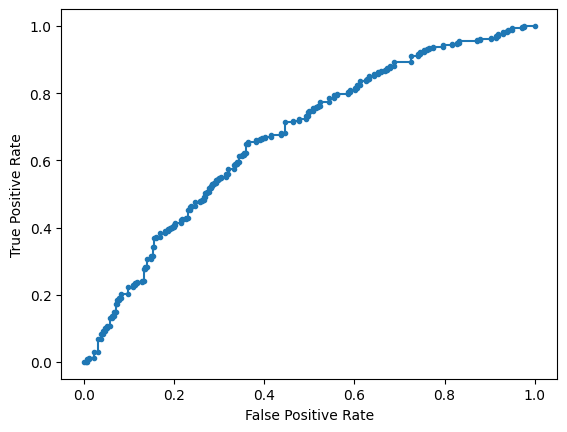

Accuracy: 64.02% Precision: 64.48% Recall: 63.98%
F1: 64.23% MCC: 0.2805
AUPRC: 62.83% AUROC: 67.00%
 accuracy [64.02321083172147]
 precision [64.47876447876449]
 recall [63.984674329501914]
 F1 [64.23076923076924]
 MCC [0.28045915112300146]
 AUPRC [62.82785011484624]
 AUROC [66.99592911877397]

Training # 2 2
2023-04-29 17:02:34.381965
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.2.2.validation_genes.txt
Discriminator ZERO -1
Train 1:0 1043:1028 50.36%
Computed class weights: {0: 1.007295719844358, 1: 0.9928092042186002}
Valid 1:0 278:258 51.87%
FIT


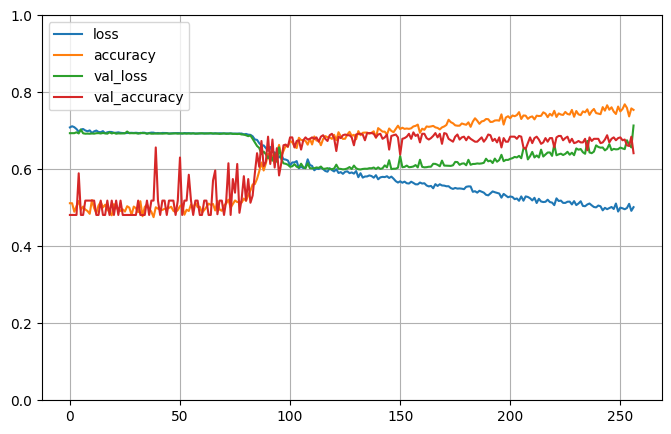


Testing # 2 2
2023-04-29 17:04:57.758244
PREDICT
Test 1:0 278:258 51.87%
Predict 1:0 275:261 51.31%
Test sizes (536, 1025) (536,)
Distrib of scores: 0.48820132 mean 0.23603857 std
Range of scores: 0.008284567 to 0.9148239
Score threshold 0.5
Confusion matrix
 [[178  80]
 [ 83 195]]
Normalized matrix
 [[0.33208955 0.14925373]
 [0.15485075 0.36380597]]
Extreme scores correct, pos:neg 113 128
Extreme scores incorrect pos:neg 45 39


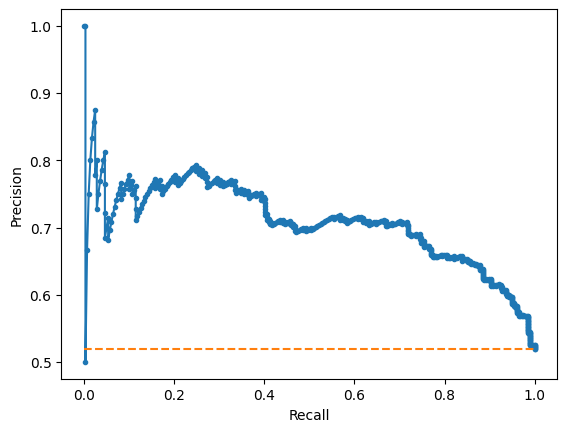

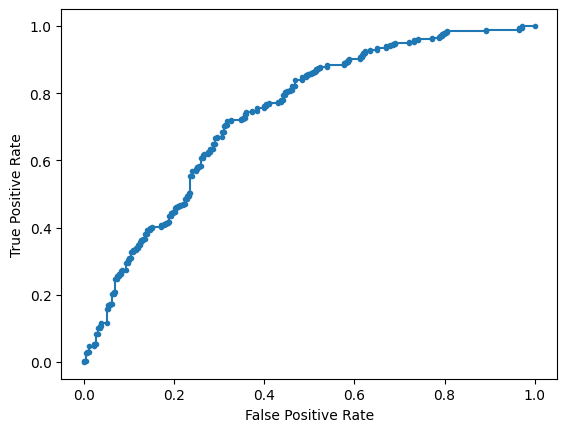

Accuracy: 69.59% Precision: 70.91% Recall: 70.14%
F1: 70.52% MCC: 0.3912
AUPRC: 70.80% AUROC: 73.76%
 accuracy [69.58955223880598]
 precision [70.9090909090909]
 recall [70.14388489208633]
 F1 [70.5244122965642]
 MCC [0.39122226319041786]
 AUPRC [70.80007398820429]
 AUROC [73.76192069600134]

Training # 2 3
2023-04-29 17:04:58.369973
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.2.3.validation_genes.txt
Discriminator ZERO -1
Train 1:0 1050:1041 50.22%
Computed class weights: {0: 1.0043227665706052, 1: 0.9957142857142857}
Valid 1:0 271:245 52.52%
FIT


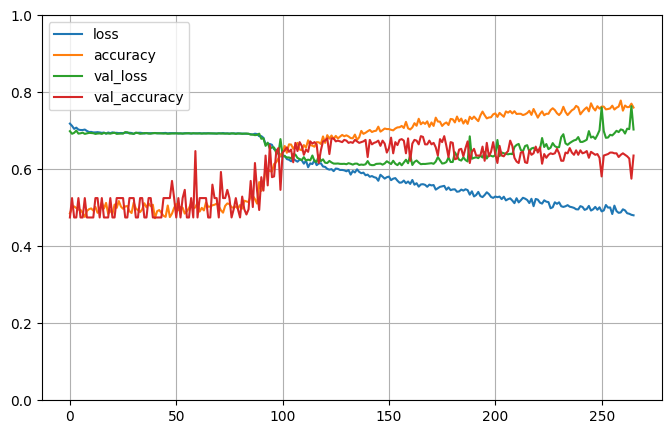


Testing # 2 3
2023-04-29 17:07:21.754796
PREDICT
Test 1:0 271:245 52.52%
Predict 1:0 323:193 62.60%
Test sizes (516, 1025) (516,)
Distrib of scores: 0.5552022 mean 0.21736278 std
Range of scores: 0.028614707 to 0.91937995
Score threshold 0.5
Confusion matrix
 [[138 107]
 [ 55 216]]
Normalized matrix
 [[0.26744186 0.20736434]
 [0.10658915 0.41860465]]
Extreme scores correct, pos:neg 141 84
Extreme scores incorrect pos:neg 64 14


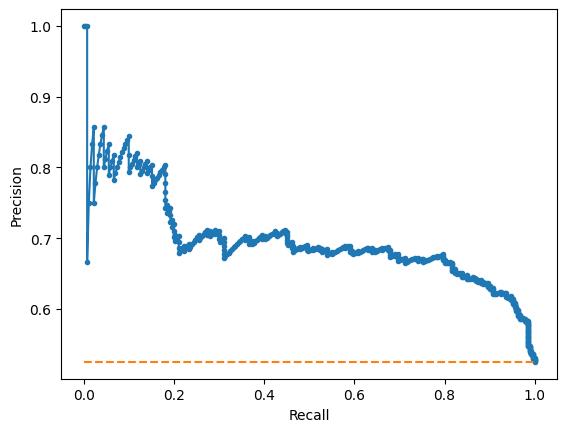

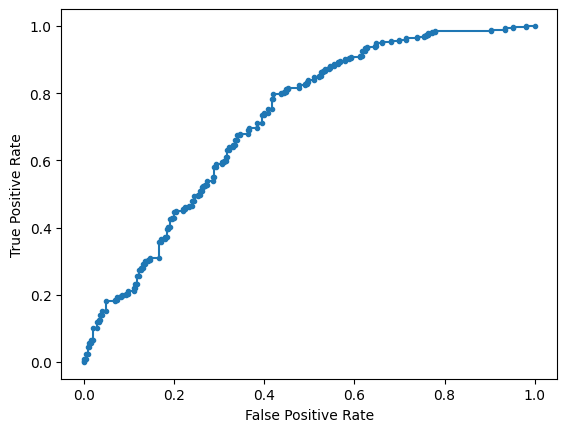

Accuracy: 68.60% Precision: 66.87% Recall: 79.70%
F1: 72.73% MCC: 0.3719
AUPRC: 69.79% AUROC: 71.85%
 accuracy [68.6046511627907]
 precision [66.87306501547987]
 recall [79.70479704797047]
 F1 [72.7272727272727]
 MCC [0.37185021504739635]
 AUPRC [69.79496226893436]
 AUROC [71.85330220649146]

Training # 2 4
2023-04-29 17:07:22.380995
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.2.4.validation_genes.txt
Discriminator ZERO -1
Train 1:0 1080:1019 51.45%
Computed class weights: {0: 1.0299313052011776, 1: 0.9717592592592592}
Valid 1:0 241:267 47.44%
FIT


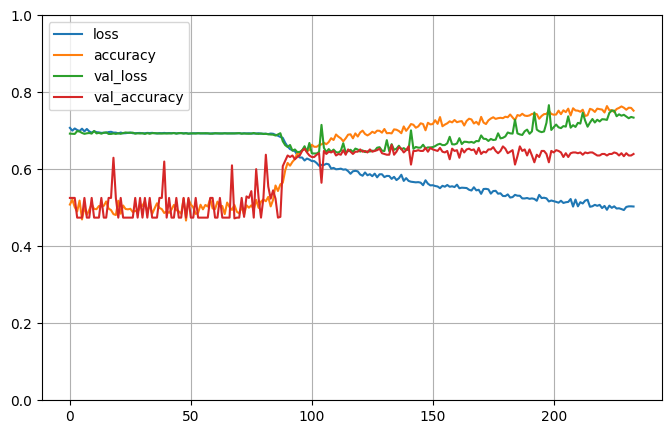


Testing # 2 4
2023-04-29 17:09:46.295762
PREDICT
Test 1:0 241:267 47.44%
Predict 1:0 332:176 65.35%
Test sizes (508, 1025) (508,)
Distrib of scores: 0.572478 mean 0.20240536 std
Range of scores: 0.052645702 to 0.909916
Score threshold 0.5
Confusion matrix
 [[136 131]
 [ 40 201]]
Normalized matrix
 [[0.26771654 0.25787402]
 [0.07874016 0.39566929]]
Extreme scores correct, pos:neg 128 65
Extreme scores incorrect pos:neg 71 17


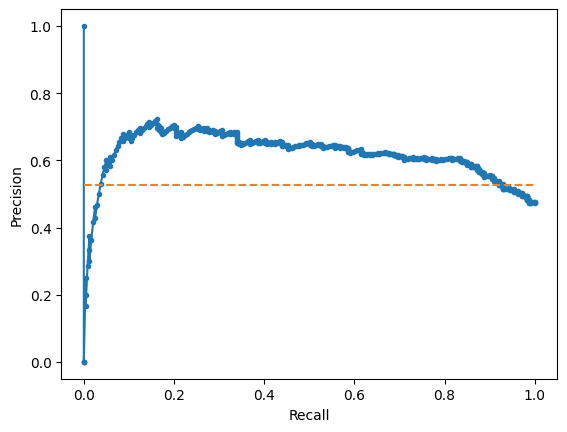

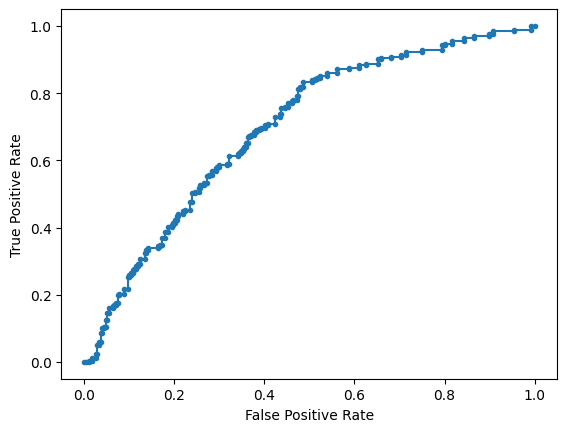

Accuracy: 66.34% Precision: 60.54% Recall: 83.40%
F1: 70.16% MCC: 0.3603
AUPRC: 61.80% AUROC: 69.72%
 accuracy [66.33858267716536]
 precision [60.54216867469879]
 recall [83.40248962655602]
 F1 [70.15706806282722]
 MCC [0.3603496740051914]
 AUPRC [61.79978033159179]
 AUROC [69.71886801249475]

Training # 2 5
2023-04-29 17:09:46.881776
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.2.5.validation_genes.txt
Discriminator ZERO -1
Train 1:0 1051:1026 50.60%
Computed class weights: {0: 1.0121832358674463, 1: 0.9881065651760228}
Valid 1:0 270:260 50.94%
FIT


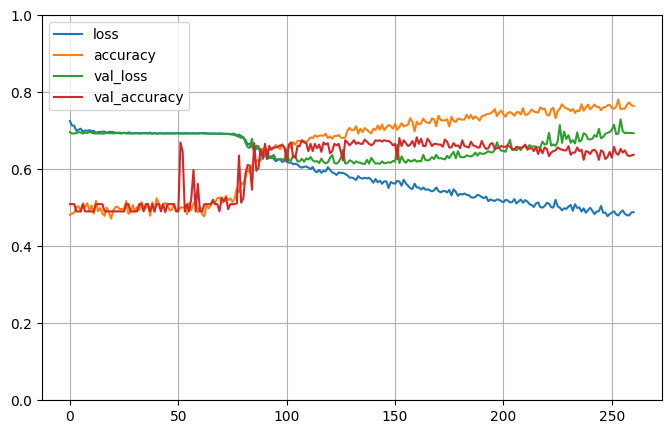


Testing # 2 5
2023-04-29 17:12:10.288137
PREDICT
Test 1:0 270:260 50.94%
Predict 1:0 274:256 51.70%
Test sizes (530, 1025) (530,)
Distrib of scores: 0.5127333 mean 0.22447994 std
Range of scores: 0.018368894 to 0.91538996
Score threshold 0.5
Confusion matrix
 [[174  86]
 [ 82 188]]
Normalized matrix
 [[0.32830189 0.16226415]
 [0.15471698 0.35471698]]
Extreme scores correct, pos:neg 122 105
Extreme scores incorrect pos:neg 44 27


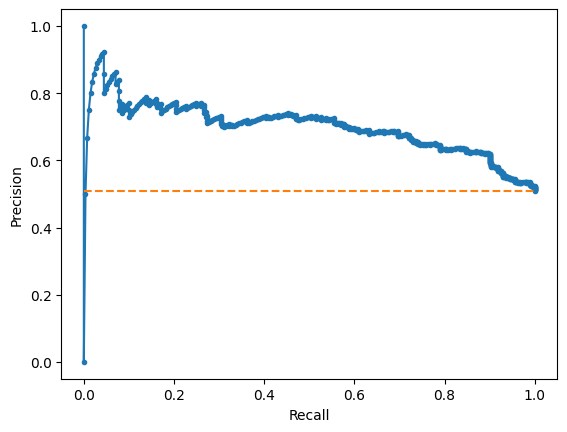

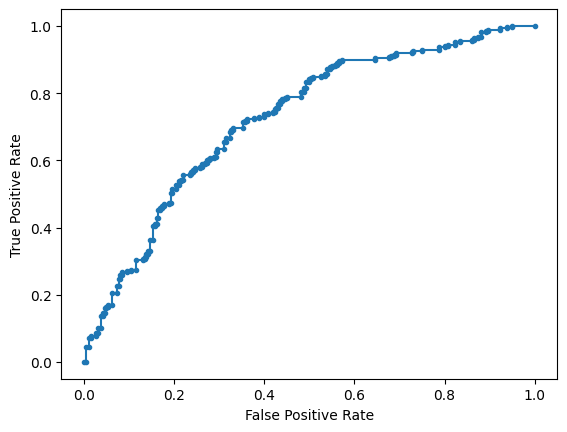

Accuracy: 68.30% Precision: 68.61% Recall: 69.63%
F1: 69.12% MCC: 0.3657
AUPRC: 69.80% AUROC: 72.44%
 accuracy [68.30188679245282]
 precision [68.61313868613139]
 recall [69.62962962962963]
 F1 [69.11764705882352]
 MCC [0.36567294708358405]
 AUPRC [69.80209421474662]
 AUROC [72.43732193732194]
2023-04-29 17:12:10.927074


In [7]:
print(datetime.now())

accuracy=[]
precision=[]
recall=[]
f1=[]
mcc=[]
auprc=[]
auroc=[]

loader = DataLoader(K,ALPHABET)
filepath = DATA_DIR+RCI_FILE_TRAIN
print("Load RCI from",filepath)
gene_to_rci = loader.load_gene_rci_values(filepath,EXCLUSIONS)
print('Num RCI:', len(gene_to_rci.keys()))
filepath = DATA_DIR+SEQ_FILE_TRAIN
print('Load sequence from',filepath)
allids,allseq = loader.load_spectra(filepath)  # for MLP (load_sequence() for CNN)
print('Loaded',len(allseq),'sequences.')
test_gene_to_rci = None
test_allids = None
test_allseq = None
if SEQ_FILE_TEST is not None:
    # Train on the entire train set (no cross-validation).
    # Evaluate with the test files.
    test_loader = DataLoader(K,ALPHABET)
    filepath = DATA_DIR+RCI_FILE_TEST
    print("Load RCI from",filepath)
    test_gene_to_rci = test_loader.load_gene_rci_values(filepath,EXCLUSIONS)
    print('Num RCI:', len(test_gene_to_rci.keys()))
    filepath = DATA_DIR+SEQ_FILE_TEST
    print('Load sequence from',filepath)
    test_allids,test_allseq = test_loader.load_spectra(filepath)
    print('Loaded',len(test_allseq),'sequences.')

for repeat in range(REPEATS):
    for fold in range(FOLDS):
        show_r = repeat+1  # display one-based counting
        show_f = fold+1    # display one-based counting

        print()
        print("Training #",show_r,show_f)
        print(datetime.now())
        builder = ModelBuilder(ALPHABET)
        cvdo = CrossValidator(EPOCHS,RCI_THRESHOLD_VALUE)
        cvdo.set_model_builder(builder)
        cvdo.set_threshold_mechanism(RCI_THRESHOLD_MECHANISM)
        
        if SEQ_FILE_TEST is None:
            # Train on 80% and evaluate on 20%.
            separator = Separator()
            separator.set_middle(FILTER_TEST,FILTER_TAILS_TEST,FILTER_MIDDLE_TEST,\
                                 FILTER_TRAIN,FILTER_TAILS_TRAIN,FILTER_MIDDLE_TRAIN,\
                                 MIDDLE_LOW,MIDDLE_HIGH)
            separator.load(DATA_DIR,show_r,show_f)
            separator.process(allids,allseq,gene_to_rci)
            train_allids,test_allids = separator.get_ids()
            train_allseq,test_allseq = separator.get_seq()
            train_gene_to_rci,test_gene_to_rci = separator.get_rci()
            cvdo.train_new_model(
                train_allids,train_allseq,train_gene_to_rci,
                test_allids,test_allseq,test_gene_to_rci)
            if SAVE_MODEL_FILENAME is not None:
                filename1 = f"{SAVE_MODEL_FILENAME}.{show_r}.{show_f}.model"
                filename2 = f"{SAVE_DESCRIM_FILENAME}.{show_r}.{show_f}.pickle"
                model,discrim = cvdo.get_models()
                save_model(model,discrim,filename1,filename2)
        else:
            # Train on the entire train set (no cross-validation).
            # Evaluate with the test files.
            train_allids = allids
            train_allseq = allseq
            train_gene_to_rci = gene_to_rci
            BREAK = True
            if LOAD_MODEL_FILENAME is not None:
                filename1 = LOAD_MODEL_FILENAME
                filename2 = LOAD_DESCRIM_FILENAME
                model, descrim = load_model(filename1, filename2)
                cvdo.set_models(model, descrim)
            else:
                cvdo.train_new_model(
                    train_allids,train_allseq,train_gene_to_rci,
                    None,None,None)

        print()
        print("Testing #",show_r,show_f)
        print(datetime.now())
        cvdo.reset_statistics()
        cvdo.test_without_training(
            test_allids,test_allseq,test_gene_to_rci)
        cv_accuracy,cv_precision,cv_recall,cv_f1,cv_mcc,cv_auprc,cv_auroc=\
            cvdo.get_statistics()

        print(" accuracy" ,  cv_accuracy)
        print(" precision" , cv_precision)
        print(" recall" ,    cv_recall)
        print(" F1" ,        cv_f1)
        print(" MCC" ,       cv_mcc)
        print(" AUPRC" ,     cv_auprc)
        print(" AUROC" ,     cv_auroc)

        accuracy.append(cv_accuracy)
        precision.append(cv_precision)
        recall.append(cv_recall)
        f1.append(cv_f1)
        mcc.append(cv_mcc)
        auprc.append(cv_auprc)
        auroc.append(cv_auroc)
        if BREAK: break
    if BREAK: break
print(datetime.now())

In [8]:
def STD (values):
    # ddof=1 reduces bias when extrapolating from sample to population
    return np.std(values,ddof=1)

print(" accuracy mean %.2f%% std %.2f" %  (np.mean(accuracy),  STD(accuracy)))
print(" precision mean %.2f%% std %.2f" % (np.mean(precision), STD(precision)))
print(" recall mean %.2f%% std %.2f" %    (np.mean(recall),    STD(recall)))
print(" F1 mean %.2f%% std %.2f" %        (np.mean(f1),        STD(f1)))
print(" MCC mean %.4f std %.4f" %       (np.mean(mcc),       STD(mcc)))
print(" AUPRC mean %.2f%% std %.2f" %     (np.mean(auprc),     STD(auprc)))
print(" AUROC mean %.2f%% std %.2f" %     (np.mean(auroc),     STD(auroc)))

print(" accuracy"  , accuracy)
print(" precision" , precision)
print(" recall"    , recall)
print(" F1"        , f1)
print(" MCC"       , mcc)
print(" AUPRC"     , auprc)
print(" AUROC"     , auroc)



 accuracy mean 67.33% std 1.67
 precision mean 65.78% std 4.06
 recall mean 75.39% std 7.82
 F1 mean 69.90% std 2.52
 MCC mean 0.3556 std 0.0315
 AUPRC mean 66.89% std 3.39
 AUROC mean 70.96% std 1.96
 accuracy [[67.10526315789474], [66.48250460405156], [66.27218934911244], [67.33067729083665], [69.21606118546845], [64.02321083172147], [69.58955223880598], [68.6046511627907], [66.33858267716536], [68.30188679245282]]
 precision [[64.6853146853147], [63.26530612244898], [62.121212121212125], [63.098591549295776], [73.25581395348837], [64.47876447876449], [70.9090909090909], [66.87306501547987], [60.54216867469879], [68.61313868613139]]
 recall [[71.42857142857143], [79.48717948717949], [81.67330677290838], [87.15953307392996], [67.25978647686833], [63.984674329501914], [70.14388489208633], [79.70479704797047], [83.40248962655602], [69.62962962962963]]
 F1 [[67.88990825688074], [70.45454545454547], [70.56798623063682], [73.20261437908498], [70.12987012987013], [64.23076923076924], [70.52